In [2]:
import numpy as np
# import my_torchbox as tb
import parseBrats as pB
import matplotlib.pyplot as plt
import scipy.ndimage as scipynd
import skimage
import matplotlib as mpl
%load_ext autoreload
%autoreload 2
from misc import *
import segmentation_TDA as sTDA
import dog
import sys
import time

# Open image

BratS lint is 6 long
i: 0 >> BraTS2021_00318
BraTS name : BraTS2021_00318
pos : (116, 82, 51)


Text(150, 225, '(T2*FLAIR)*(T2 + FLAIR)')

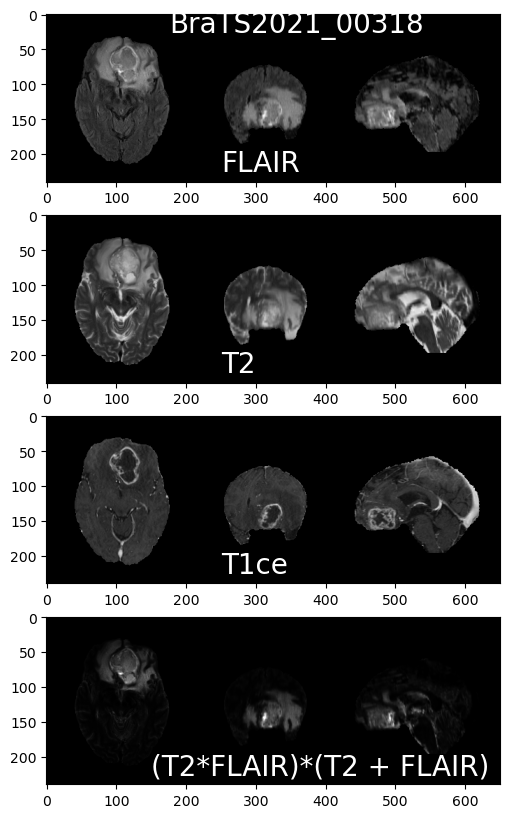

In [3]:
# brats_list = None
brats_list = ["BraTS2021_00318",'BraTS2021_01296','BraTS2021_00636','BraTS2021_00557','BraTS2021_01245','BraTS2021_00113']
pb = pB.Parse_brats(brats_list=brats_list,
                    brats_folder='2021',
                    modality='flair',
                    get_template=False)
print(f"BratS lint is {len(pb.brats_list)} long")

# i = np.random.randint(len(pb.brats_list))
i =0
# i= 161
print('i:',i,'>>',pb.brats_list[i])
img_flair,seg, = pb(i,to_torch=False,modality='flair',normalize=False)
img_t2,_, = pb(i,to_torch=False,modality='t2',normalize=False)
img_t1ce,_, = pb(i,to_torch=False,modality='t1ce',normalize=False)

# img_flair = equalize_image(patch_normalisation(img_flair))
# img_t2 = equalize_image(patch_normalisation(img_t2))
# img_t1ce = patch_normalisation(img_t1ce)


mask = (img_flair != 0)
new_image = img_flair.copy()
new_image[mask] = (img_flair[mask] * img_t2[mask])*(img_flair[mask] + img_t2[mask])
# new_image = new_image/new_image.max()
# new_image = equalize_image(new_image)

seg[seg > 0] =1
print(f"BraTS name : {pb.brats_list[i]}")
sigma= 3
img_b = scipynd.gaussian_filter(img_flair, sigma=sigma)
pos= sTDA.argmax_image(new_image,sign=-1)
print('pos :', pos)
# img_t2_b = scipynd.gaussian_filter(img_t2, sigma=sigma)
%matplotlib inline
fig,ax = plt.subplots(4,1,figsize=(12,10))
ax[0].imshow(make_3d_flat(img_flair,pos ),cmap='gray',vmax=1)
# ax[1].imshow(make_3d_flat(seg_true, pos),cmap='gray')
# plotMask(make_3d_flat(seg_union,pos),make_3d_flat(img_flair,pos),ax=ax[1], origin='upper')
ax[0].text(175,25,pb.brats_list[i],c='white',fontsize=20)
ax[0].text(250,225,'FLAIR',c='white',fontsize=20)
ax[1].imshow(make_3d_flat(img_t2,pos ),cmap='gray',vmax=1)

ax[1].text(250,225,'T2',c='white',fontsize=20)
ax[2].imshow(make_3d_flat(img_t1ce,pos ),cmap='gray',vmax=1)
ax[2].text(250,225,'T1ce',c='white',fontsize=20)
ax[3].imshow(make_3d_flat(new_image,pos ),cmap='gray',vmax=1)
ax[3].text(150,225,'(T2*FLAIR)*(T2 + FLAIR)',c='white',fontsize=20)

# Normalisation par patchs

In [4]:
def select_nonoverlapping_patches(image, num_patches_depth, num_patches_height, num_patches_width):
    """
    Selects non-overlapping patches from a 3D image using a vectorized approach, by specifying the number of patches in each dimension.
    :return: torch tensor of dimensions: (num_patches_depth, num_patches_height, num_patches_width, patch_size[0], patch_size[1], patch_size[2])
    """
    image_depth, image_height, image_width = image.shape[:3]

    # Calculate the patch size and stride in each dimension
    patch_size_depth = image_depth // num_patches_depth
    patch_size_height = image_height // num_patches_height
    patch_size_width = image_width // num_patches_width
    stride_depth = patch_size_depth
    stride_height = patch_size_height
    stride_width = patch_size_width
    print(f"stride = {stride_depth,stride_height,stride_width}")

    # Generate the indices for the top-left corner of each patch
    patch_indices = np.meshgrid(
        np.arange(0, image_depth - patch_size_depth + 1, stride_depth),
        np.arange(0, image_height - patch_size_height + 1, stride_height),
        np.arange(0, image_width - patch_size_width + 1, stride_width)
    )
    print(f"patch_indices ,1= {patch_indices[0].shape}")
    # Flatten the indices into a single tensor
    patch_indices = np.stack(patch_indices, axis=-1)
    print(f"patch_indices ,2= {patch_indices.shape}")
    patch_indices = patch_indices.reshape(-1, 3)
    print(f"patch_indices ,3= {patch_indices.shape}")
    print(patch_indices[50])

    # Extract the patches using the indices
    patches = np.empty(
        (num_patches_depth*num_patches_height*num_patches_width,
         patch_size_depth,patch_size_height,patch_size_width)
    )
    for i,index in enumerate(patch_indices):
        patches[i] =  image[
              index[0]:index[0]+stride_depth,
              index[1]:index[1]+stride_height,
              index[2]:index[2]+stride_width
              ]
    print('patches : ',patches.shape)
    # patches = patches.reshape(num_patches_depth, num_patches_height, num_patches_width, patch_size_depth, patch_size_height, patch_size_width)

    return patches,

def reconstruct_image_from_patches(patches,num_patches, image_shape):
    image_depth, image_height, image_width = image_shape
    num_patches_depth, num_patches_height, num_patches_width = num_patches

    # Calculate the patch size and stride in each dimension
    patch_size_depth = image_depth // num_patches_depth
    patch_size_height = image_height // num_patches_height
    patch_size_width = image_width // num_patches_width
    stride_depth = patch_size_depth
    stride_height = patch_size_height
    stride_width = patch_size_width

    # Generate the indices for the top-left corner of each patch
    patch_indices = np.meshgrid(
        np.arange(0, image_depth - patch_size_depth + 1, stride_depth),
        np.arange(0, image_height - patch_size_height + 1, stride_height),
        np.arange(0, image_width - patch_size_width + 1, stride_width)
    )
    patch_indices = np.stack(patch_indices, axis=-1)
    patch_indices = patch_indices.reshape(-1, 3)

    # Create a zero-initialized image of the required size
    image = np.zeros((image_depth, image_height, image_width))

    # Fill the image with the patches
    for i,index in enumerate(patch_indices):
        image[
            index[0]:index[0]+stride_depth,
            index[1]:index[1]+stride_height,
            index[2]:index[2]+stride_width
        ] += patches[i]

    return image

@time_it
def patch_normalisation(image,num_patches = (8,8,8)):
    num_patches_depth,num_patches_height,num_patches_width = num_patches

    # Extract the patches
    patches, = select_nonoverlapping_patches(image, num_patches_depth, num_patches_height, num_patches_width)

    ## Renormalisation
    mean_im, var_im = image[image>0].mean(), image[image>0].std()
    print(mean_im, var_im)
    patches_norm = np.zeros(patches.shape)
    for i,p in enumerate(patches):
        if p.mean() >0:
            patches_norm[i] = (p - mean_im)/var_im

    image_norm = reconstruct_image_from_patches(
        patches_norm,
        (num_patches_depth,num_patches_height,num_patches_width),
        image.shape
    )
    # Put back image between 0 and 1
    print(f'normalise min,max = {image_norm.min()}, {image_norm.max()}')
    image_norm[image_norm == 0] = image_norm.min()
    image_norm = (image_norm - image_norm.min())/(image_norm.max() - image_norm.min())

    return image_norm

# Load the 3D MRI image
image = img_flair.copy()

image_norm = patch_normalisation(image,num_patches = (8,8,8))


%matplotlib qt
fig,ax = plt.subplots(3,1,figsize=(12,10))
ax[0].imshow(make_3d_flat(image,pos ),cmap='gray',vmax=1)
# ax[1].imshow(make_3d_flat(seg_true, pos),cmap='gray')
# plotMask(make_3d_flat(seg_union,pos),make_3d_flat(img_flair,pos),ax=ax[1], origin='upper')
ax[0].text(175,25,'original',c='white',fontsize=20)
ax[1].imshow(make_3d_flat(image_norm,pos ),cmap='gray',vmax=1)
ax[1].text(250,225,'Normalised',c='white',fontsize=20)
ax[2].imshow(make_3d_flat(image - image_norm,pos ),cmap='cividis')

stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.39301546641638363 0.07254815271439512
normalise min,max = -5.417304944532391, 8.366643544642281

Computation of patch_normalisation done in  0:00:00s and 0.153cents  s


stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.39301546641638363 0.07254815271439512
normalise min,max = -5.417304944532391, 8.366643544642281

Computation of patch_normalisation done in  0:00:00s and 0.150cents  s
stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.19762706201240385 0.08478031892313716
normalise min,max = -2.3310488156051274, 9.464141538734207

Computation of patch_normalisation done in  0:00:00s and 0.149cents  s
stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.31916661156558607 0.0786655235865765
normalise min,max = -4.057261644160069, 8.654787477326236

Computation of patch_normalisation done in  0:00:00s and 0.147cents  s
stride = (30, 30, 19)
patch_indices ,

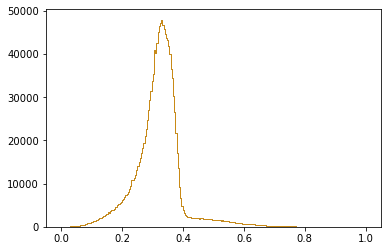

In [62]:
img_flair_pn = patch_normalisation(img_flair.copy())
img_t2_pn = patch_normalisation(img_t2.copy())
img_t1ce_pn = patch_normalisation(img_t1ce.copy())
new_image_pn = patch_normalisation(new_image.copy())


fig,ax = plt.subplots()
ax.hist(img_t1ce[img_t1ce >0].flatten(), bins=256,range= (0,1), color='black', alpha=0.7, histtype='step')
ax.hist(img_t1ce_pn[img_t1ce_pn >0].flatten(), bins=256,range= (0,1), color='orange', alpha=0.7, histtype='step')
plt.show()


# Equalisation:

In [76]:
@time_it
def equalize_image(image):
    # Calculate the cumulative distribution function (CDF)
    image_flat = image.flatten()
    hist, bins = np.histogram(image_flat[image_flat>0], bins=256, range=(0,1))
    cdf = np.cumsum(hist)

    # Normalize the CDF to span the entire dynamic range
    cdf_normalized = cdf / cdf[-1]

    # Create a lookup table for the intensity values
    lut = np.interp(image_flat, bins[:-1], cdf_normalized)

    # Apply the lookup table to the image to equalize it
    image_equalized = lut.reshape(image.shape)

    return image_equalized

img_flair_eq = patch_normalisation( equalize_image(img_flair.copy()))
img_t2_eq = patch_normalisation( equalize_image(img_t2.copy()))
img_t1ce_eq = patch_normalisation( equalize_image(img_t1ce.copy()))
new_image_eq = patch_normalisation( equalize_image(new_image.copy()))
%matplotlib qt
fig,ax = plt.subplots(1,2,figsize = (20,5))
ax[0].hist(img_flair[img_flair >0].flatten(), bins=256,range= (0,1), color='black', alpha=0.7, histtype='step')
ax[0].hist(img_flair_eq[img_flair_eq >0].flatten(), bins=256,range= (0,1), color='orange', alpha=0.7, histtype='step')
ax[1].imshow(make_3d_flat(img_flair_eq,pos), cmap='gray')
plt.show()


Computation of equalize_image done in  0:00:00s and 0.087cents  s
stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.5202537392131121 0.2883435392057305
normalise min,max = -1.8042843638744261, 1.6638009719530882

Computation of patch_normalisation done in  0:00:00s and 0.144cents  s

Computation of equalize_image done in  0:00:00s and 0.110cents  s
stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.08471550351588064 0.2228719114507627
normalise min,max = -0.37797091951618433, 4.106773664416324

Computation of patch_normalisation done in  0:00:00s and 0.210cents  s

Computation of equalize_image done in  0:00:00s and 0.086cents  s
stride = (30, 30, 19)
patch_indices ,1= (8, 8, 8)
patch_indices ,2= (8, 8, 8, 3)
patch_indices ,3= (512, 3)
[180   0  38]
patches :  (512, 30, 30, 19)
0.520

# Edges detection using dog

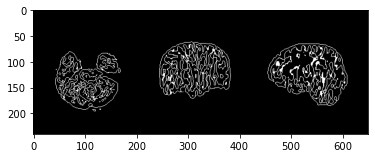

In [12]:


# nib_flair,seg, = pb(i,to_torch=False,modality='flair',get_nib= True)
# flair_edges = dog.dog_img(nib_flair,fwhm=3, verbose =0)

flair_edges = pb.get_edges(i,'flair')

# flair_edges.get_fdata()
%matplotlib inline
fig,ax = plt.subplots()
ax.imshow(make_3d_flat(flair_edges,pos ),cmap='gray',vmax=1)

## SUSAN

(116, 82, 51)
(240, 12, 155)

Computation of susan_edge_detection done in  0:00:05s and 0.622cents  s
(240, 12, 155) 1.0


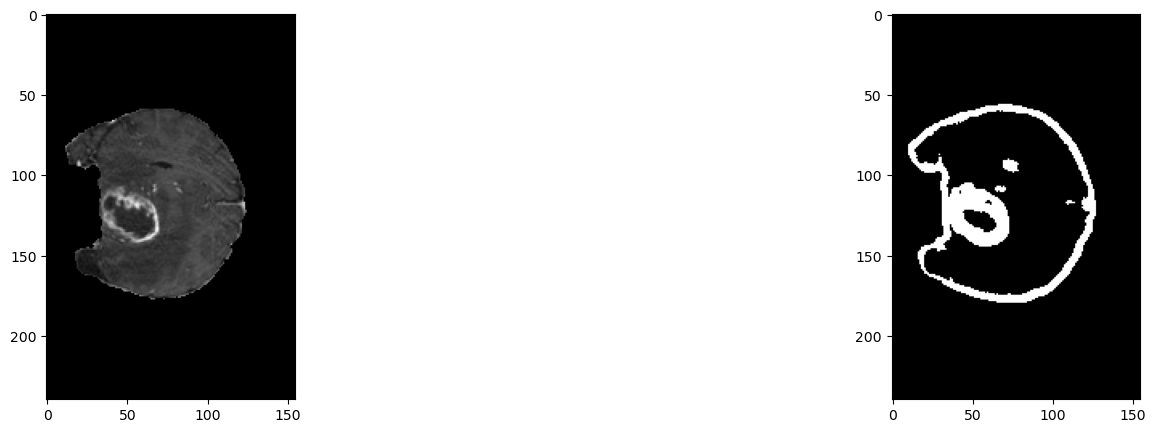

In [25]:
@time_it
def susan_edge_detection(image, t, radius):
    # Create a circular mask
    x, y, z = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    mask = np.sqrt(x**2 + y**2 + z**2) <= radius

    # Initialize the edge map
    edge_map = np.zeros_like(image)

    # Calculate the mean intensity of each segment
    for i in range(radius, image.shape[0] - radius):
        for j in range(radius, image.shape[1] - radius):
            for k in range(radius, image.shape[2] - radius):
                segment = image[i-radius:i+radius+1, j-radius:j+radius+1, k-radius:k+radius+1]
                mean_intensity = np.mean(segment)
                # print(mean_intensity)
                # Count the number of pixels within the circular mask that have an intensity difference less than the threshold t
                num_pixels = np.sum(mask * ((segment - mean_intensity) ** 2 < t**2))

                # If the number of pixels is less than a certain threshold, mark the pixel as an edge
                if num_pixels < 38:
                    edge_map[i, j, k] = 1

    return edge_map

# cut a slice of the image
print(pos)
img_flair_slice = img_t1ce[:,pos[1]-6:pos[1]+6,:]
print(img_flair_slice.shape)
flair_edges_susan = susan_edge_detection(img_flair_slice, t=.03, radius=3)
print(flair_edges_susan.shape,flair_edges_susan.max())
fig,ax = plt.subplots(1,2,figsize = (20,5))
ax[0].imshow(img_flair_slice[:,6], cmap='gray')
ax[1].imshow(flair_edges_susan[:,6], cmap='gray',vmax=1)

In [41]:
@time_it
def susan_noise_reduction(image, t, radius):
    # Create a circular mask
    x, y, z = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    mask = np.sqrt(x**2 + y**2 + z**2) <= radius

    # Initialize the denoised image
    denoised_image = np.zeros_like(image)

    # Calculate the mean intensity of each segment
    for i in range(radius, image.shape[0] - radius):
        for j in range(radius, image.shape[1] - radius):
            for k in range(radius, image.shape[2] - radius):
                segment = image[i-radius:i+radius+1, j-radius:j+radius+1, k-radius:k+radius+1]
                mean_intensity = np.mean(segment)

                # Count the number of pixels within the circular mask that have an intensity difference less than the threshold t
                num_pixels = np.sum(mask * ((segment - mean_intensity) ** 2 < t**2))

                # If the number of pixels is greater than a certain threshold, replace the center pixel with the mean intensity of the segment
                if num_pixels > 27:
                    denoised_image[i, j, k] = mean_intensity
                else:
                    denoised_image[i, j, k] = image[i, j, k]

    return denoised_image

%matplotlib qt
img_flair_slice = img_flair[:,pos[1]-6:pos[1]+6,:]
flair_denoised_susan = susan_noise_reduction(img_flair_slice, t=0.1, radius=2)
diff = img_flair_slice - flair_denoised_susan
fig,ax = plt.subplots(1,4,figsize = (10,5))
# ax[0].imshow(make_3d_flat(img_flair,pos), cmap='gray')
# ax[1].imshow(make_3d_flat(flair_denoised_susan,pos), cmap='gray')
ax[0].imshow(img_flair_slice[:,6], cmap='gray')
ax[1].imshow(flair_denoised_susan[:,6], cmap='gray',vmax=1)
ax[2].imshow(diff[:,6], cmap='gray',vmax=1)
ax[3].plot(img_flair_slice[:,6,pos[1]//2],label='original')
ax[3].plot(flair_denoised_susan[:,6,pos[1]//2],label='denoised')
ax[3].legend()
plt.show()


Computation of susan_noise_reduction done in  0:00:07s and 0.513cents  s


In [39]:
plt.figure()
plt.plot(img_flair_slice[:,6,pos[1]//2])
plt.plot(flair_denoised_susan[:,6,pos[1]//2])
plt.show()

In [ ]:
from scipy.ndimage import generic_filter

@time_it
def susan_noise_reduction_fast(image, t, radius):
    def create_circular_mask(height, width, depth, center=None, radius=None):
        if center is None:  # use the middle of the image by default
            center = (int(height/2), int(width/2), int(depth/2))
        if radius is None:  # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], center[2], height-center[0], width-center[1], depth-center[2])
        Y, X, Z = np.ogrid[:height, :width, :depth]
        dist_from_center = np.sqrt((Y - center[0])**2 + (X - center[1])**2 + (Z - center[2])**2)
        mask = dist_from_center <= radius
        return mask

    def local_mean(arr):
        return np.mean(arr[mask])

    # Apply the local mean filter to the input image
    denoised_image = generic_filter(image, local_mean, size=(2*radius+1, 2*radius+1, 2*radius+1), mode='constant', cval=0)

    # Replace the center pixel with the mean intensity of the segment if the number of pixels within the circular mask that have an intensity difference less than the threshold t is greater than a certain threshold
    mask = create_circular_mask(2*radius+1, 2*radius+1, 2*radius+1)
    num_pixels = np.sum(mask)
    intensity_difference = np.abs(image - denoised_image)
    intensity_difference_masked = intensity_difference[mask][0]
    num_pixels_masked = np.sum(intensity_difference_masked < t)
    denoised_image[intensity_difference_masked < t] = (num_pixels_masked / num_pixels) * denoised_image[intensity_difference_masked < t] + (1 - num_pixels_masked / num_pixels) * image[intensity_difference_masked < t]

    return denoised_image

flair_denoised_susan_fast = susan_noise_reduction_fast(img_flair, t=0.3, radius=3)
fig,ax = plt.subplots(1,3,figsize = (20,5))
ax[0].imshow(make_3d_flat(img_flair,pos), cmap='gray')
ax[1].imshow(make_3d_flat(flair_denoised_susan,pos), cmap='gray')
ax[2].imshow(make_3d_flat(flair_denoised_susan_fast,pos), cmap='gray')